In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")
from parameter_class import fit_parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import emcee
import chisq
from generate_TFcube import get_TFcube_pars, get_data_TFcube

sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")
from binnedFit_utilities import *

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
sini = 0.9
g1 = 0.0
g2 = 0.1

eint_thy = cal_e_int(sini=sini)
eobs_thy = cal_e_obs(e_int=eint_thy, gamma1=g1)
theta_obs = cal_theta_obs(e_int=eint_thy, gamma2=g2)

slitAng_major_p = theta_obs
slitAng_minor_p = theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

eobs_thy: 0.6361256544502619
slitAng_major_p: 9.00699085349689
slitAng_minor_p: 99.0069908534969


In [3]:
#TF_pars = load_pickle("/Users/hhg/Research/kinematic_lensing/data/TF_pars.pickle")
#meta_parameters = ("/Users/hhg/Research/kinematic_lensing/data/meta_parameters.pickle")

#data = load_pickle("/Users/hhg/Research/kinematic_lensing/data/data.pickle")
#noise = load_pickle("/Users/hhg/Research/kinematic_lensing/data/noise.pickle")
#obslambda = np.load("/Users/hhg/Research/kinematic_lensing/data/obslambda.npy")


update_TF, _ = get_TFcube_pars()

update_TF['g1'] = g1
update_TF['g2'] = g2
update_TF['sini'] = sini
update_TF['vcirc'] = 200. 

update_TF['n_knots'] = 25.
update_TF['knot_fraction'] = 0.0
update_TF['throughput'] = 0.29
update_TF['slitWidth'] = 0.05
update_TF['psfFWHM'] = 0.5
update_TF['pixScale'] = 0.1185# 0.1185  # 0.032 

update_TF['redshift'] = 0.2
update_TF['Resolution'] = 6000.
update_TF['nm_per_pixel'] = 0.033 #0.033 # 0.025
update_TF['expTime'] = 3600.0 
update_TF['linelist']['flux'][update_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
update_TF['lambda_min'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] - 2
update_TF['lambda_max'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] + 2
update_TF['norm'] = 0.
update_TF['ngrid'] = 256
update_TF['image_size'] = 128
update_TF['slitAngles'] = np.array([slitAng_minor_p])

TF_pars, meta_parameters = get_TFcube_pars(update_TF)

%time data, noise, obslambda = get_data_TFcube(TF_pars, meta_parameters, return_lambda=True)


# make data_info from Prangal's data output

data_info = {}
data_info['ModelCube'] = None
data_info['ObsCube'] = None
data_info['image'] = data['image']
data_info['image_variance'] = noise['image']

if len(TF_pars['slitAngles']) == 1:
    data_info['data'] = data['spectra'][0]
else:
    data_info['data_list'] = data['spectra']
    
data_info['grid_lambda'] = obslambda

extent =  TF_pars['image_size'] * TF_pars['pixScale']
subGridPixScale = extent*1./TF_pars['ngrid']

data_info['grid_pos']  = np.arange(-extent/2., extent/2., subGridPixScale)
data_info['grid_Image'] = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
data_info['par_fid']   = TF_pars
data_info['lambda_emit'] = 656.461 # Halpha [nm]

returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
CPU times: user 7.24 s, sys: 170 ms, total: 7.41 s
Wall time: 5.99 s


In [18]:
# original data gen IO
# data_info = gen_dataInfo_from_tfCube(redshift=0.2, vcirc=200., sini=0.8, g1=0.0, g2=0.0, slitAngles=[0.0])

# 2D spectrum

In [8]:
# init Fit tool
RotFit = RotationCurveFit(data_info, active_par_key = ['vcirc'], par_fix={'sini':1.0}, e_obs=bestfit_e_obs, sigma_TF_intr=0.08)

# find fitting parameter using optimizer
if 'sini' in RotFit.active_par_key:
    params_rot = RotFit.optFit_rotation_curve(RotFit.gaussfit_peakLambda, par_init_guess={'vscale':0.5, 'vcirc':200, 'sini':0.5})
    print(params_rot)
else:
    print('optFit_rotation_curve only works if sini is in active_par_key')
    
    
# find fitting parameters using MCMC (get error bars as well)
chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=3000)
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

  1%|          | 23/3000 [00:00<00:13, 225.36it/s]

time cost in gaussFit_spec2D: 0.16297698020935059 (secs)
optFit_rotation_curve only works if sini is in active_par_key


100%|██████████| 3000/3000 [00:11<00:00, 255.74it/s]

Total MCMC time (mins): 0.1956295847892761


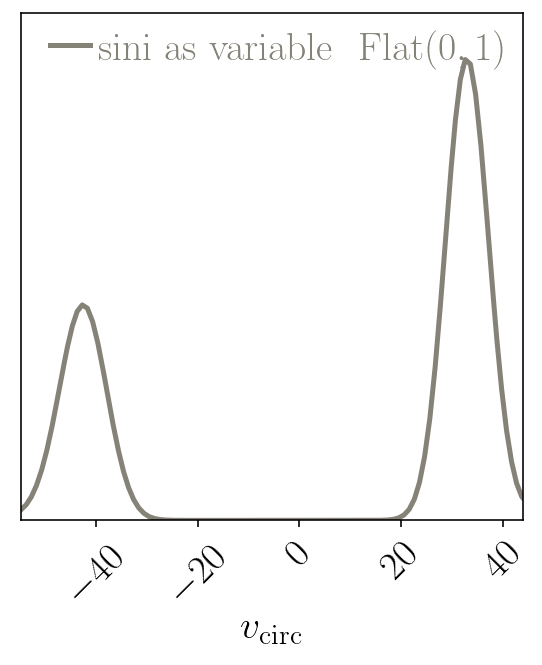

In [10]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['vcirc']
legend_chain = "$\mathrm{sini\ as\ variable\ \ Flat(0,1)}$"

if 'cosi' in RotFit.active_par_key:
    select_par_key = select_par_key + ['cosi']
    legend_chain = "$\mathrm{cosi\ as\ variable\ \ Flat(0,1)}$"


parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]       , parameters=parName1 ,name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

## Plot spectrum

In [22]:
GaussFit = GaussFit_spec2D(data_info)

fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D(data=GaussFit.data)
model = GaussFit.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)
data = GaussFit.data

# get pixel edges
lambda_min = np.min(GaussFit.grid_lambda)  ; lambda_MAX = np.max(GaussFit.grid_lambda)
x_min = np.min(GaussFit.grid_pos)          ; x_MAX = np.max(GaussFit.grid_pos)

time cost in gaussFit_spec2D: 0.15817904472351074 (secs)


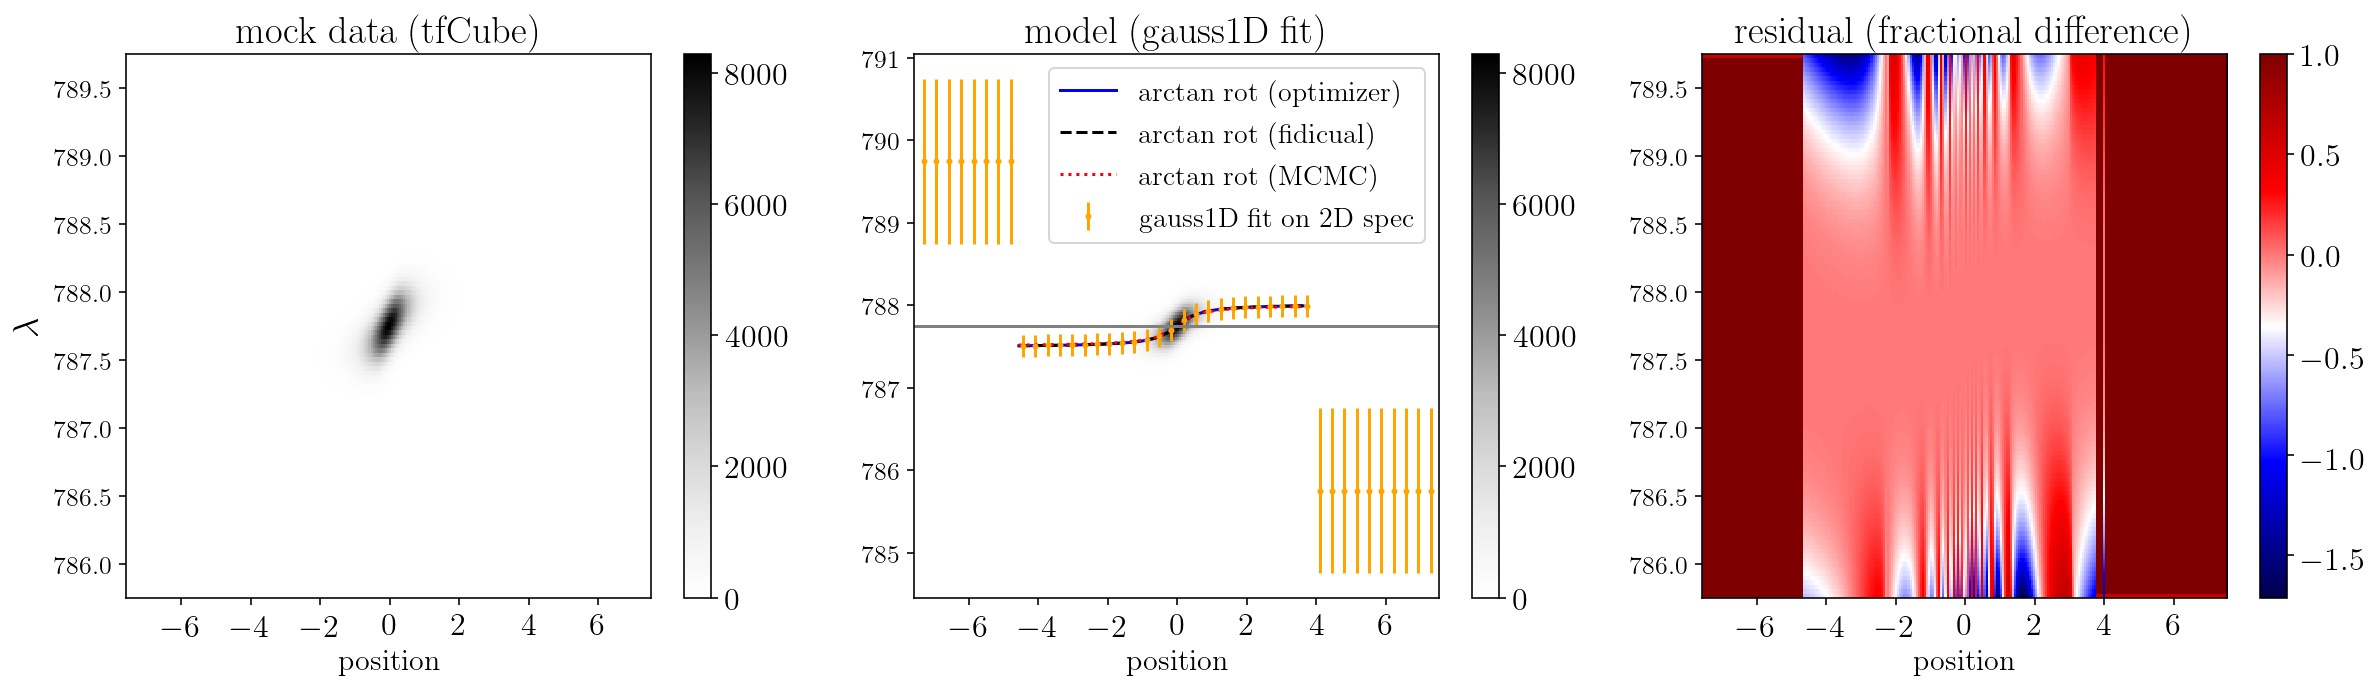

In [41]:
#%matplotlib
%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(20,5))
plt.rc('font',size=16)

img0=ax[0].imshow(data.T , extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img1=ax[1].imshow(model.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img2=ax[2].imshow((data.T-model.T)/data.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap=plt.cm.seismic, origin="lower")
fig.colorbar(img2, ax=ax[2])
fig.colorbar(img0, ax=ax[0])
fig.colorbar(img1, ax=ax[1])


#### gaussfit image peak identification summary (yellow)
ax[1].errorbar(GaussFit.grid_pos[5::6], fitted_peakLambda[5::6], fitted_sigma[5::6] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')

#### result of optimizer fit (blue)
ax[1].plot(RotFit.grid_pos[2::6], RotFit.fitted_rot_lambdaObs[2::6],color='b',ls='-',label='arctan rot (optimizer)')

#### result of fiducial rotation curve (black)
par = RotFit.Parameter.par_fid.copy()
fidicual_rot = RotFit.model_arctan_rotation(RotFit.grid_pos, vscale=par['vscale'], r_0=par['r_0'], vcirc=par['vcirc'], v_0=par['v_0'], redshift=par['redshift'], sini=par['sini'])
ax[1].plot(RotFit.grid_pos[2::6],fidicual_rot[2::6],color='k',ls='--',label='arctan rot (fidicual)')

#### result of bestfit from MCMC sampling (red)
par_bestfit_MC = Chain.par_bestfit(select_par_key=None, statistics='max', mode=0)
MC_rot = RotFit.model_arctan_rotation(RotFit.grid_pos, vscale=par_bestfit_MC['vscale'][1], r_0=par['r_0'], vcirc=par_bestfit_MC['vcirc'][1], v_0=par['v_0'], redshift=par['redshift'], sini=par_bestfit_MC['sini'][1])
ax[1].plot(RotFit.grid_pos[2::6],MC_rot[2::6],color='r',ls=':',label='arctan rot (MCMC)')


lambda_cen = data_info['lambda_emit']*(1.+data_info['par_fid']['redshift'])

ax[1].axhline(lambda_cen, color='gray')

for j in range(ncol):
    #ax[j].set_ylim(vcen-1.5,vcen+1.5)
    #ax[j].set_xlim(-3.5,3.5)
    ax[j].set_xlabel('position', fontsize=15)
    ax[j].tick_params(axis='x', labelsize=16)
    ax[j].tick_params(axis='y', labelsize=13)
    ax[j].set_xticks([-6, -4, -2, 0, 2, 4, 6])

ax[0].set_ylabel(r'$\lambda$', fontsize=18)    
ax[0].set_title('mock data (tfCube)')
ax[1].set_title('model (gauss1D fit)')
ax[2].set_title('residual (fractional difference)')

#ax[1].legend(loc=(2.3,0.75),prop={'size':16})
ax[1].legend(loc="best",prop={'size':14})

plt.show()

Text(0, 0.5, 'arcmin')

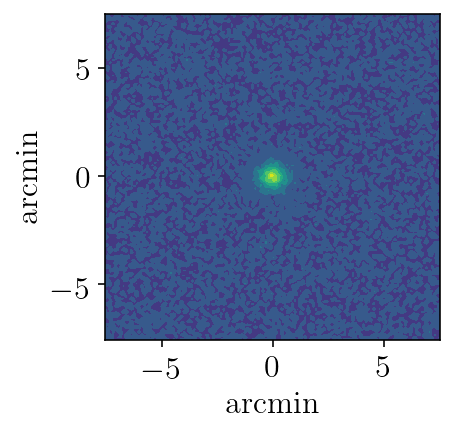

In [39]:
# check image
fig, ax = plt.subplots(1,1, figsize=(3.,3.))
ax.contourf(data_info['image'] ,extent=[x_min, x_MAX, x_min, x_MAX])

ax.set_xlabel('arcmin')
ax.set_ylabel('arcmin')

# ---- END ----

In [29]:
import emcee
import numpy as np

def log_prior(params):
    return -0.5 * np.sum(params**2)

def log_like(params):
    return -0.5 * np.sum((params / 0.1)**2)

def log_prob(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf, -np.inf
    ll = log_like(params)
    if not np.isfinite(ll):
        return lp, -np.inf
    return lp + ll, lp

coords = np.random.randn(32, 3)
nwalkers, ndim = coords.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(coords, 100)

log_prior_samps = sampler.get_blobs()
flat_log_prior_samps = sampler.get_blobs(flat=True)

print(log_prior_samps.shape)  # (100, 32)
print(flat_log_prior_samps.shape)  # (3200,)

(100, 32)
(3200,)


In [30]:
log_prior_samps.shape

(100, 32)

In [31]:
sampler.get_last_sample().coords

array([[ 0.05572895,  0.12600331, -0.08879216],
       [-0.05603232, -0.02829232,  0.08101665],
       [-0.04522076,  0.02183684,  0.00053161],
       [-0.23587283,  0.04881639, -0.09821291],
       [-0.04763391,  0.09196948,  0.01440725],
       [-0.00298993,  0.01323101, -0.12484826],
       [-0.06874977, -0.05646532, -0.12777474],
       [-0.03069946,  0.1933827 ,  0.23485318],
       [ 0.19548966, -0.12591382, -0.14558117],
       [ 0.05347321,  0.03327055,  0.01236159],
       [-0.00442328,  0.02783355, -0.22067213],
       [-0.18915341, -0.08011074, -0.13622982],
       [ 0.0251554 , -0.0405737 ,  0.06839639],
       [-0.05908674,  0.32368516, -0.00933369],
       [ 0.09674396, -0.10026578, -0.11839361],
       [-0.03028813, -0.06402046, -0.09451331],
       [ 0.05877696, -0.09051738, -0.21089764],
       [-0.02947342, -0.07638625, -0.02571074],
       [ 0.03646105, -0.1811459 , -0.00542663],
       [ 0.1903986 ,  0.06819881,  0.07651697],
       [ 0.09553796, -0.02284252,  0.044